In [5]:
import sys
sys.path.append("..")
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from LowLevelModules.Spectroscopy import Spectrum
from LowLevelModules.GeneralFunctions import get_work_dir, prettify_plot, prettify_2d_plot
import numpy as np
import os
# user input
wdir = r'Z:\Projects\WSe2\2019\03 march\03112019 Bottom and top gated WSe2\cold spectra\spot4'
## fetch all SPE files in folder
files = [f for f in os.listdir(wdir) if '.spe' in f]
filenames = [f[:-4] for f in files if not 'raw' in f]
#filenames

In [6]:
import ipywidgets as widgets
from IPython.display import display
normalize_choice = widgets.Checkbox(
    value=False,
    description='Normalize and shift',
    disabled=False
)

etaloning_choice = widgets.Checkbox(
    value=True,
    description='Remove CCD etaloning',
    disabled=False
)
fit_choice = widgets.Checkbox(
    value=False,
    description='Fit data with 2 Voigt profiles',
    disabled=False
)

x_axis_choice = widgets.RadioButtons(
    options=['Wavelength (nm)', 'Energy (eV)'],
    value='Wavelength (nm)',
    description='X axis unit:',
    disabled=False
)
display(etaloning_choice)
display(normalize_choice)
display(fit_choice)
display(x_axis_choice)

Checkbox(value=True, description='Remove CCD etaloning')

Checkbox(value=False, description='Normalize and shift')

Checkbox(value=False, description='Fit data with 2 Voigt profiles')

RadioButtons(description='X axis unit:', options=('Wavelength (nm)', 'Energy (eV)'), value='Wavelength (nm)')

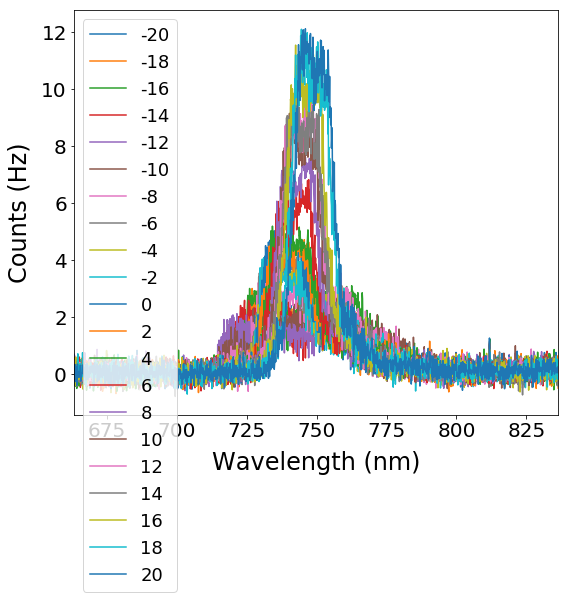

In [7]:
#filenames = [filenames[0]]
# fitting bounds on two peaks a01, x01, sigma1, gamma1, a02, x02, sigma2, gamma2
bds = ([.1, 700, 0.1, 0.1, 0.1, 700, 0.1, 0.1],[np.inf, 800, 50, 50, np.inf, 800, 50, 50])
volts = range(-20,22,2)

#plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cts = np.zeros(1340,)
nd_counts = []   # for the 2d voltage/spectra plot
for i, f in enumerate(filenames):
    # plot everything
    file = wdir + '\\' + f + '.spe'
    data = Spectrum(file)
    data.remove_cosmic_ray(2)
    if etaloning_choice.value:
        data.remove_etaloning(0.30, 0.46, 0.02, plotplot=False)
    if x_axis_choice.value == 'Energy (eV)':
        data.x = 1241/data.x
        data.x = data.x[::-1]
        data.y = data.y[::-1]
    nd_counts.append(data.y)
    if normalize_choice.value:
        data.y = data.y / np.max(data.y) + i*0.5
    
    ax.plot(data.x, data.y, '-')  
    if fit_choice.value:
        y_arrf, y_arr1, y_arr2 = data.fit_2voigt(bds)
        ax.plot(data.x, y_arrf, 'r')
        ax.fill(data.x, y_arr1, 'g', facecolor='green', alpha=0.1)
        ax.fill(data.x, y_arr2, 'g', facecolor='green', alpha=0.1)


#axis limits
plt.xlim(data.x[0], data.x[-1])
#plt.ylim(0, 1.05*np.max(data.y))
#special cases
#plt.xlim(730, 740)
#plt.ylim(0, 3)

#legend
ax.legend(volts, prop={'size': 18})
prettify_plot(ax, x_axis_choice.value, "Counts (Hz)")
fig.tight_layout()

In [11]:
fig.savefig(wdir + '\\' + f + x_axis_choice.value[:-4] + '.png', format='png', bbox_inches='tight')

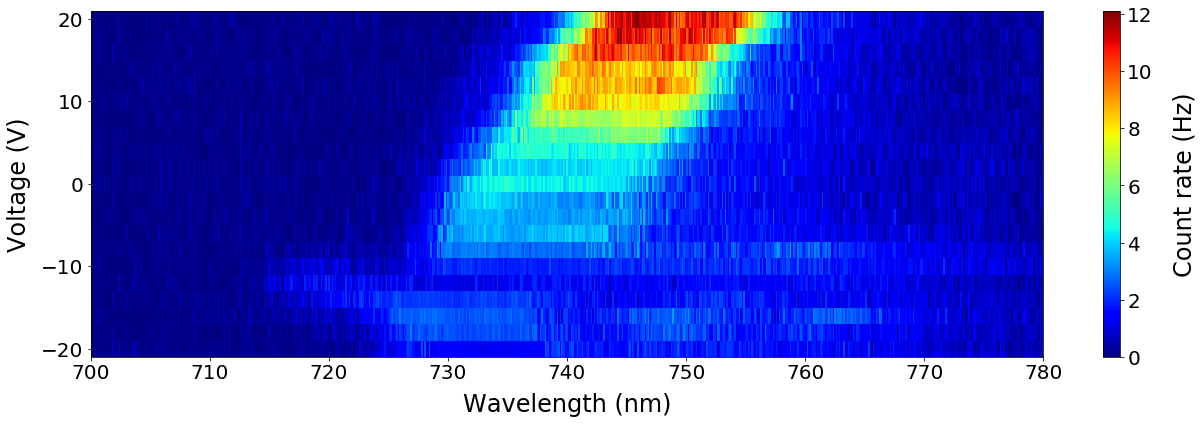

In [8]:
# plot spectral voltage scan in 2D
from matplotlib.colors import LogNorm
x = data.x
#shifts the data to make plot correct
dx = x[1]-x[0]
x = np.append(x - dx/2, x[-1] + dx/2)
y = np.array(volts)
#shifts the data to make plot correct
dy = y[1]-y[0]
y = np.append(y - dy/2, y[-1] + dy/2)
z = np.array(nd_counts)

fig2 = plt.figure(figsize=(18,6))
ax2 = fig2.add_subplot(111)
p2 = ax2.pcolor(x, y, z, cmap='jet', vmin=0, vmax=np.max(z)) #norm=LogNorm(vmin=0, vmax=np.max(z))) #
cb2 = fig2.colorbar(p2)
prettify_2d_plot(ax2, cb2, x_axis_choice.value, 'Voltage (V)', 'Count rate (Hz)')
if x_axis_choice.value == 'Energy (eV)':
    plt.xlim(1.6, 1.75)
else:
    plt.xlim(700, 780)
fig2.tight_layout()

In [21]:
fig2.savefig(wdir + '\\' + f + '2dVoltagescan' + x_axis_choice.value[:-4] +'.png', format='png', bbox_inches='tight')